### Step1: Load Data set

In [13]:
import sys
import pandas as pd # Create a fake module path that old pickle expects 
sys.modules['pandas.indexes'] = pd.core.indexes
import pickle

with open("data/LSWMD.pkl", "rb") as f:
    data = pickle.load(f, encoding="latin1")




C:\Users\giris\AppData\Local\Temp\ipykernel_6980\4269243681.py:7: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  data = pickle.load(f, encoding="latin1")


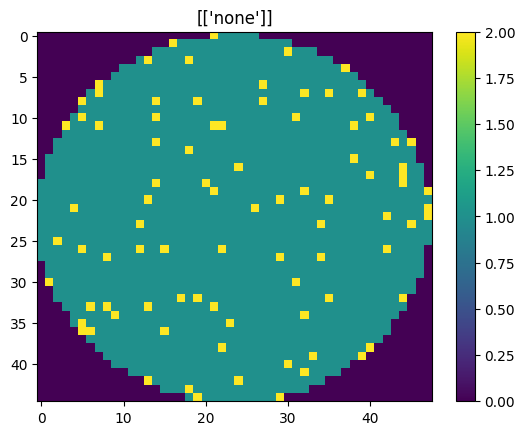

In [14]:
import matplotlib.pyplot as plt

plt.imshow(data["waferMap"][0], cmap="viridis")
plt.title(data["failureType"][0])
plt.colorbar()
plt.show()


### STEP2: DATA Understanding (EDA)

In [15]:
#Inspect datset structure
data.keys()

Index(['waferMap', 'dieSize', 'lotName', 'waferIndex', 'trianTestLabel',
       'failureType'],
      dtype='str')

In [16]:
#Check size of wafer map
print("Data set size:"  + str(len(data["waferMap"])))

Data set size:811457


In [17]:
#Explore labels for defect types
# Extract a simple scalar label first, then count with Counter (fast).
from collections import Counter

ft = data["failureType"]

def _extract_label(x):
    # Handles entries like [['none']] as well as empty arrays or unexpected shapes.
    try:
        if x is None:
            return None
        arr = getattr(x, "ravel", None)
        if arr is None:
            return str(x)
        flat = x.ravel()
        if flat.size == 0:
            return None
        v = flat[0]
        if v is None:
            return None
        return str(v)
    except Exception:
        return None

flat_labels = [_extract_label(x) for x in ft.to_numpy()]
missing = sum(lbl is None for lbl in flat_labels)

# Keep only real defect labels (exclude None and the literal 'none' class).
labels = [
    l for l in flat_labels
    if (l is not None) and (str(l).strip() != "") and (str(l).strip().lower() != "none")
],
labels = labels[0]  # unpack the one-element tuple created above

# Printing every label to notebook output can freeze VS Code/Jupyter.
# So we write them all to a file, and show a small preview here.
out_path = "data/non_null_labels_excluding_none.txt"
with open(out_path, "w", encoding="utf-8") as f_out:
    for l in labels:
        f_out.write(l + "\n")

print("Non-null, excluding 'none':", len(labels))
print("Missing/empty labels:", missing)
print("Wrote defect labels to:", out_path)
print("Preview (first 20):", labels[:20])

counts = Counter(labels)
pd.Series(counts).sort_values(ascending=False)

Non-null, excluding 'none': 25519
Missing/empty labels: 638507
Wrote defect labels to: data/non_null_labels_excluding_none.txt
Preview (first 20): ['Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Center', 'Loc', 'Edge-Loc', 'Center', 'Loc', 'Edge-Ring', 'Scratch', 'Edge-Ring', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc']


Edge-Ring    9680
Edge-Loc     5189
Center       4294
Loc          3593
Scratch      1193
Random        866
Donut         555
Near-full     149
dtype: int64

In [18]:
# inspection: size + element types
ft = data["failureType"]
print("len(failureType):", len(ft))
print("type(failureType):", type(ft))
print("first element type:", type(ft[0]))
print("first element:", ft[0])


len(failureType): 811457
type(failureType): <class 'pandas.Series'>
first element type: <class 'numpy.ndarray'>
first element: [['none']]


<Axes: >

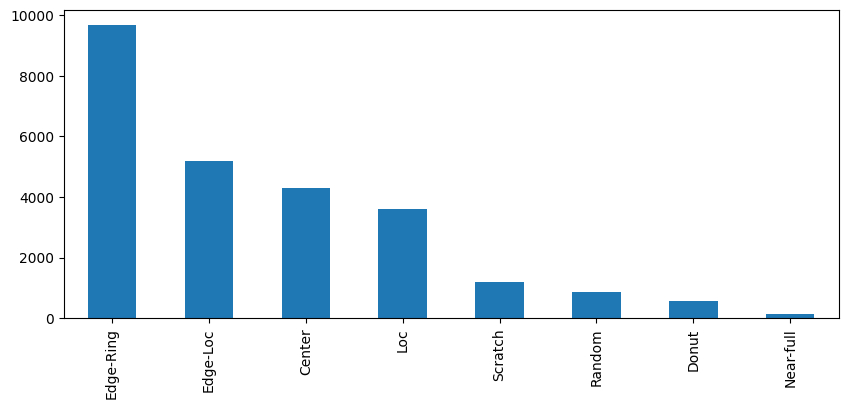

In [19]:
pd.Series(labels).value_counts().plot(kind="bar", figsize=(10,4))

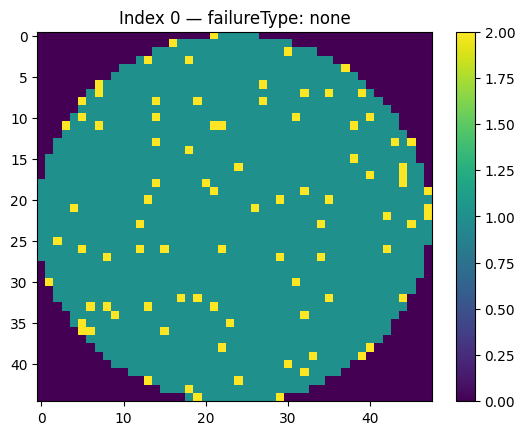

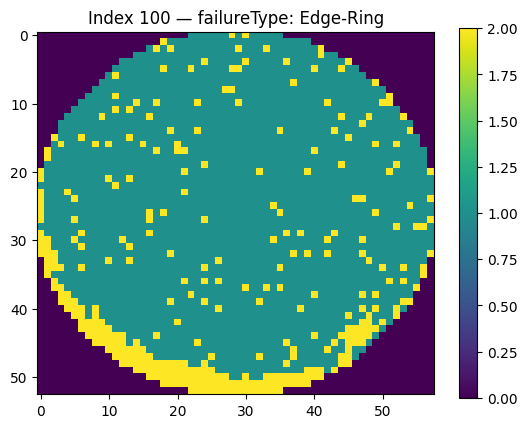

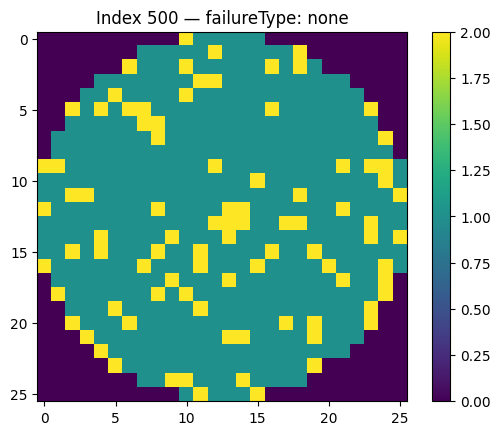

In [20]:
# visualize few wafer maps with their labels
import matplotlib.pyplot as plt
import numpy as np

def _extract_label(x):
    # Reuse the same idea as earlier: flatten arrays like [['none']] -> 'none'
    try:
        if x is None:
            return None
        flat = x.ravel() if hasattr(x, "ravel") else None
        if flat is None or flat.size == 0:
            return None
        return str(flat[0])
    except Exception:
        return None

def show_wafer(idx):
    wafer = np.array(data["waferMap"][idx])
    raw_label = data["failureType"][idx]
    label = _extract_label(raw_label)
    label = label if label is not None else "(missing)"


    plt.imshow(wafer, cmap="viridis")
    plt.title(f"Index {idx} — failureType: {label}")
    plt.colorbar()
    plt.show()

show_wafer(0)
show_wafer(100)
show_wafer(500)


In [21]:
#Check wafer map shapes, we will need to handle varying sizes for CNN and flatterning for classical ML
shapes = [np.array(w).shape for w in data["waferMap"]]
pd.Series(shapes).value_counts().head()

(32, 29)    108687
(25, 27)     64083
(49, 39)     39323
(26, 26)     30078
(30, 34)     29513
Name: count, dtype: int64

In [22]:
# Check for missing or corrupted maps
import numpy as np

bad = [i for i, w in enumerate(data["waferMap"]) if w is None or np.array(w).size == 0]
len(bad)


0

In [23]:
# Resize wafer maps to a fixed size (32x32) so we can stack them
# Note: resizing makes pixel values FLOATS due to interpolation.
import numpy as np
import pandas as pd
from skimage.transform import resize

def resize_wafer(w, size=32):
    w = np.array(w)
    w = np.nan_to_num(w)
    return resize(w, (size, size), mode="reflect", anti_aliasing=True)

# Keep indices so PCA labels stay aligned with subset rows
subset_idxs = [
    i for i, w in enumerate(data["waferMap"][:5000])
    if w is not None and np.array(w).size > 0
]
subset = np.stack([resize_wafer(data["waferMap"][i], size=32).ravel() for i in subset_idxs])

print("subset shape:", subset.shape)
pixels = subset.ravel()
display(pd.Series(pixels).describe())

subset shape: (5000, 1024)


count    5.120000e+06
mean     3.616899e-03
std      1.942192e-03
min      0.000000e+00
25%      3.921569e-03
50%      3.921569e-03
75%      4.469210e-03
max      7.843137e-03
dtype: float64

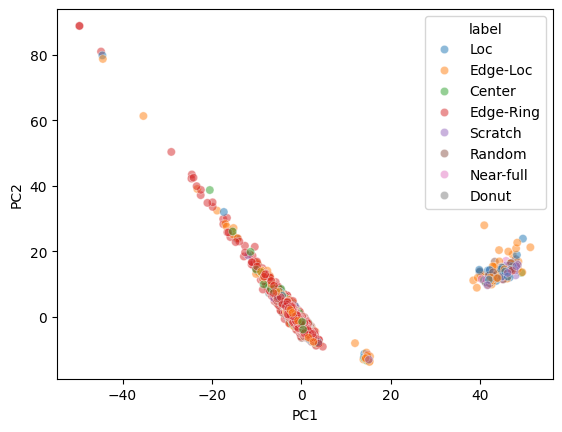

In [25]:
# PCA preview (handles varying wafer map shapes + keeps labels aligned)
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

subset = np.nan_to_num(subset)

scaler = StandardScaler()
subset_scaled = scaler.fit_transform(subset)

pca = PCA(n_components=2)
proj = pca.fit_transform(subset_scaled)

proj_df = pd.DataFrame(proj, columns=["PC1", "PC2"])
proj_df["label"] = labels[:len(proj_df)]

sns.scatterplot(data=proj_df, x="PC1", y="PC2", hue="label", alpha=0.5)
plt.show()


### 3. Data Preparation

In [26]:
# Creating binary labels (normal vs defective)
import numpy as np
import pandas as pd

def _extract_label(x):
    try:
        if x is None:
            return None
        flat = x.ravel() if hasattr(x, "ravel") else None
        if flat is None or flat.size == 0:
            return None
        return str(flat[0])
    except Exception:
        return None

labels = pd.Series([_extract_label(x) for x in data["failureType"].to_numpy()])
binary_labels = labels.apply(lambda s: 0 if (s is None or str(s).strip().lower() == "none") else 1)
binary_labels.value_counts()


1    664026
0    147431
Name: count, dtype: int64

In [56]:
# resize all wafer maps to a consistent shape (32,32) for model training
# we use vectorized resizing for faster processing
import cv2
import numpy as np

def resize_fast(w, size=32):
    w = np.array(w).astype("float32")
    return cv2.resize(w, (size, size), interpolation=cv2.INTER_AREA)

N = 800000  # use shorter sample for faster testing
subset_maps = data["waferMap"][:N]
subset_labels = binary_labels[:N]

X_resized = np.array([resize_fast(w) for w in subset_maps])
X_flat = X_resized.reshape(N, -1)





### STEP4: Modelling

In [57]:
#Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_flat, subset_labels, 
    test_size=0.2, 
    random_state=42, 
    stratify=subset_labels
)

In [58]:
#Scaling the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [59]:
#Logistic Regression model
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(
    class_weight="balanced", 
    max_iter=500
)

logreg.fit(X_train_scaled, y_train)
preds_logreg = logreg.predict(X_test_scaled)

#evaluate model
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, preds_logreg))
print(confusion_matrix(y_test, preds_logreg))


              precision    recall  f1-score   support

           0       0.53      0.90      0.67     27420
           1       0.97      0.84      0.90    132580

    accuracy                           0.85    160000
   macro avg       0.75      0.87      0.78    160000
weighted avg       0.90      0.85      0.86    160000

[[ 24551   2869]
 [ 21730 110850]]


In [60]:
#Random Forest model
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42
)

rf.fit(X_train, y_train)
preds_rf = rf.predict(X_test)

#Evaluate model
print(classification_report(y_test, preds_rf))


              precision    recall  f1-score   support

           0       0.85      0.81      0.83     27420
           1       0.96      0.97      0.97    132580

    accuracy                           0.94    160000
   macro avg       0.90      0.89      0.90    160000
weighted avg       0.94      0.94      0.94    160000



In [61]:
# Gradient Boosting model (Xgboost)
from xgboost import XGBClassifier

xgb = XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=5  # helps with imbalance
)

xgb.fit(X_train, y_train)
preds_xgb = xgb.predict(X_test)

#Evaluate model
print(classification_report(y_test, preds_xgb))


              precision    recall  f1-score   support

           0       0.92      0.47      0.63     27420
           1       0.90      0.99      0.94    132580

    accuracy                           0.90    160000
   macro avg       0.91      0.73      0.79    160000
weighted avg       0.91      0.90      0.89    160000



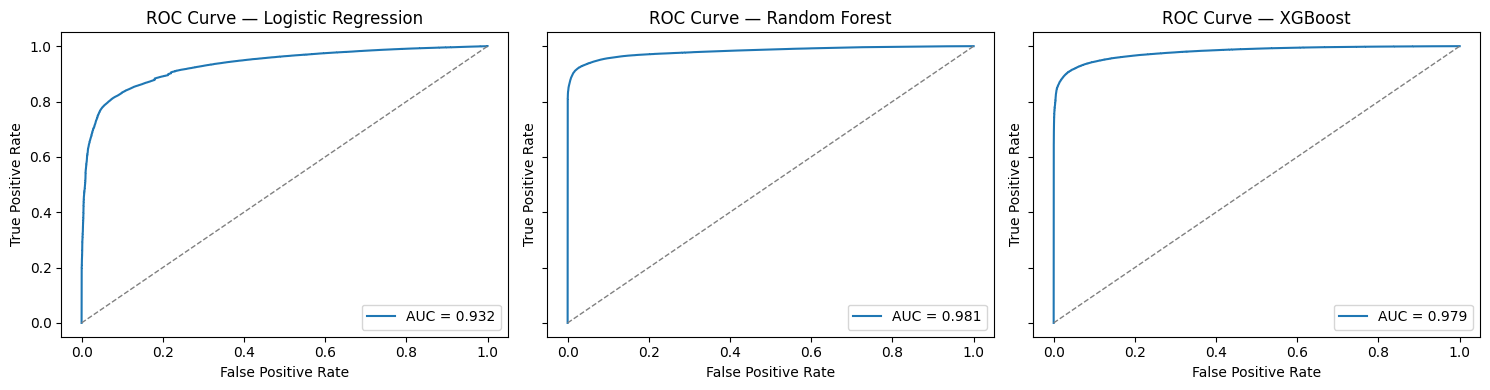

In [64]:
# ROC subplots: Logistic Regression vs Random Forest vs XGBoost
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

models = [
    ("Logistic Regression", logreg, X_test_scaled),
    ("Random Forest", rf, X_test),
    ("XGBoost", xgb, X_test),
]

for ax, (name, model, X_eval) in zip(axes, models):
    probs = model.predict_proba(X_eval)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    ax.plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1)
    ax.set_title(f"ROC Curve — {name}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")

plt.tight_layout()
plt.show()

### 5 Model performance comparison

In [63]:
from sklearn.metrics import classification_report

print("Logistic Regression")
print(classification_report(y_test, preds_logreg))

print("Random Forest")
print(classification_report(y_test, preds_rf))

# If you trained XGBoost:
print("XGBoost")
print(classification_report(y_test, preds_xgb))


Logistic Regression
              precision    recall  f1-score   support

           0       0.53      0.90      0.67     27420
           1       0.97      0.84      0.90    132580

    accuracy                           0.85    160000
   macro avg       0.75      0.87      0.78    160000
weighted avg       0.90      0.85      0.86    160000

Random Forest
              precision    recall  f1-score   support

           0       0.85      0.81      0.83     27420
           1       0.96      0.97      0.97    132580

    accuracy                           0.94    160000
   macro avg       0.90      0.89      0.90    160000
weighted avg       0.94      0.94      0.94    160000

XGBoost
              precision    recall  f1-score   support

           0       0.92      0.47      0.63     27420
           1       0.90      0.99      0.94    132580

    accuracy                           0.90    160000
   macro avg       0.91      0.73      0.79    160000
weighted avg       0.91      0.9

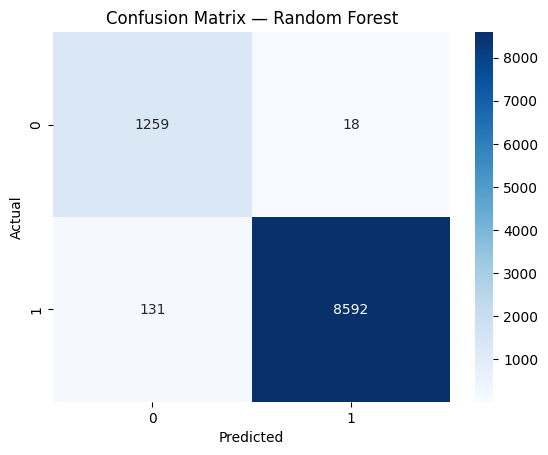

Confusion Matrix:

Top-left (TN): correctly predicted normal wafers

Top-right (FP): normal wafers incorrectly predicted as defective

Bottom-left (FN): defective wafers incorrectly predicted as normal

Bottom-right (TP): correctly predicted defective wafers



In [53]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, preds_rf)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Random Forest")
plt.show()

print("Confusion Matrix:\n")
print("Top-left (TN): correctly predicted normal wafers\n")
print("Top-right (FP): normal wafers incorrectly predicted as defective\n")
print("Bottom-left (FN): defective wafers incorrectly predicted as normal\n")
print("Bottom-right (TP): correctly predicted defective wafers\n")

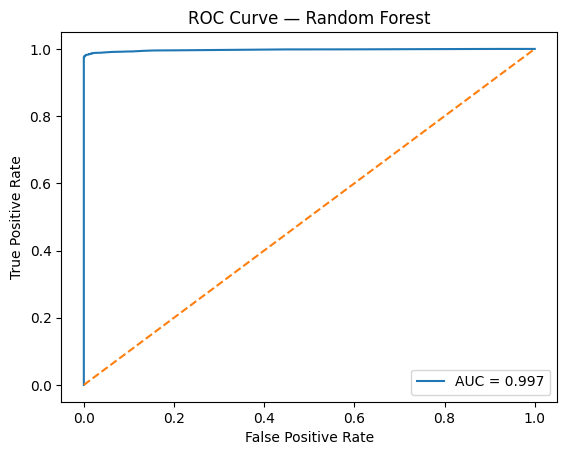

In [54]:
# ROC Curve + AUC
from sklearn.metrics import roc_curve, auc

probs = rf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Random Forest")
plt.legend()
plt.show()


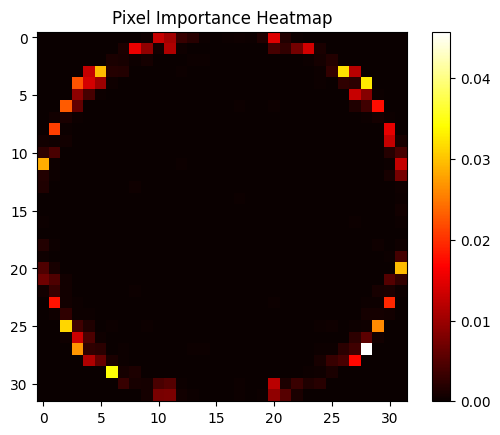

In [55]:
# Feature inportance from Random Forest
import numpy as np

importances = rf.feature_importances_
top_pixels = np.argsort(importances)[-20:]

top_pixels
plt.imshow(importances.reshape(32,32), cmap="hot")
plt.title("Pixel Importance Heatmap")
plt.colorbar()
plt.show()


### CRISP-DM Diagram

In [70]:
from graphviz import Digraph

# Create directed graph
g = Digraph("CRISP_DM", format="png")
g.attr(rankdir="LR", size="10,5")
g.attr("node", shape="rectangle", style="filled", color="lightblue", fontsize="14")

# CRISP-DM phases
phases = [
    "Business Understanding",
    "Data Understanding",
    "Data Preparation",
    "Modeling",
    "Evaluation",
    "Deployment"
]

# Add nodes
for p in phases:
    g.node(p)

# Add straight bent arrows (not arc)
for i in range(len(phases) - 1):
    g.edge(phases[i], phases[i + 1], arrowhead="normal")

# Feedback loops
g.edge("Evaluation", "Business Understanding", style="dashed", arrowhead="vee", constraint="false")


# Save diagram
g.render("./report/crisp_dm_diagram", cleanup=True)

print("CRISP-DM diagram generated: crisp_dm_diagram.png")


CRISP-DM diagram generated: crisp_dm_diagram.png
